# **EKG Sinyalinin  Filtrelenmesi**

**EKG nedir?**

Elektrokardiyografi (EKG), kalbin kulakçıkları ,  kasılma ve gevşeme aşamalarında, kalbin uyarılması ve uyaranın iletimi sırasında biyoelektrik aktivitenin ölçümüdür. EKG sinyali, belirli koşullara karşılık gelen bazı özel dalgalara sahiptir.

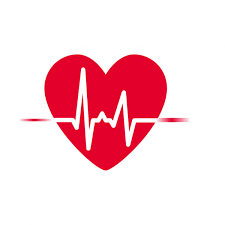

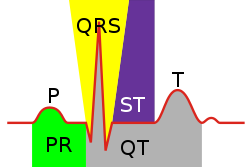

---



  - Normal bir EKG'de P, QRS ve T diye adlandırılan 3 dalga ve bunlar arasında düz çizgiler vardır. Bu dalga ve çizgilerdeki değişiklikler normalden sapmaları gösterir. P dalgası kulakçıkların uyarı ile kasılmasını, QRS dalgası karıncıklara geçen uyarının bunları kasmasını, T dalgası karıncıkların sakin hale gelmesini gösterir. Dalgalar arasındaki mesafeler dalgaların süresi yükseklikleri (voltajları), şekilleri, düzenli olarak birbirlerini takip etmelerindeki değişiklikler kalpte olabilecek yapı değişikliğini veya hastalığı gösterebilir.
  - Sağlıklı bir yetişkinde ve normal koşullar altında, QRS kompleksinin süresi 0,06 ile 0,10 saniye arasında olacaktır.
  

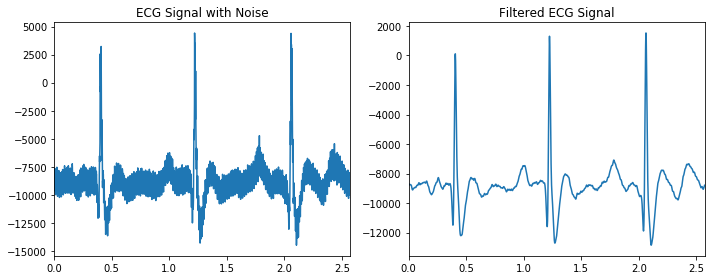
- https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

- Temiz bir EKG sinyalinin frekans aralığı 0,05 Hertz ila 100 Hertz arasındadır, ancak sinyalin EKG izleme cihazı aracılığıyla iletilmesi ve alınması sırasında güç hattı paraziti, taban çizgisi kayması, kanal gürültüsü, Elektromiyogram(Kas hareket) gürültüsü gibi farklı sesler, elektrot temas gürültüsü ortaya çıkabilir.
- Elimizdeki veride bulunan bu tür gürültülerin analizini yapıp filtre yardımı ile bu gürültüleri temizlemeyi amaçlamaktayız.

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from scipy import signal

In [2]:
data = pd.read_csv('ekg.csv')
data

,Time (s),Channel 1 (V)
0,-1.12925,-0.015717
1,-1.12900,-0.013341
2,-1.12875,-0.015038
3,-1.12850,-0.012662
4,-1.12825,-0.015378
...,...,...
7995,0.86950,-0.019451
7996,0.86975,-0.021828
7997,0.87000,-0.018093
7998,0.87025,-0.018093


In [3]:
max=np.max(data['Channel 1 (V)'])
min=np.min(data['Channel 1 (V)'])
print('max deger:',max,'\n','min deger:',min)

max deger: 0.21106134269515 
 min deger: -0.071053626236427


In [4]:
max=np.max(data['Time (s)'])
min=np.min(data['Time (s)'])
print('max deger:',max,'\n','min deger:',min)

max deger: 0.8705 
 min deger: -1.12925


In [5]:
f_sample = 1/(data['Time (s)'][1]-data['Time (s)'][0])
print (f_sample)
data.head()

3999.9999999986644


,Time (s),Channel 1 (V)
0,-1.12925,-0.015717
1,-1.12900,-0.013341
2,-1.12875,-0.015038
3,-1.12850,-0.012662
4,-1.12825,-0.015378


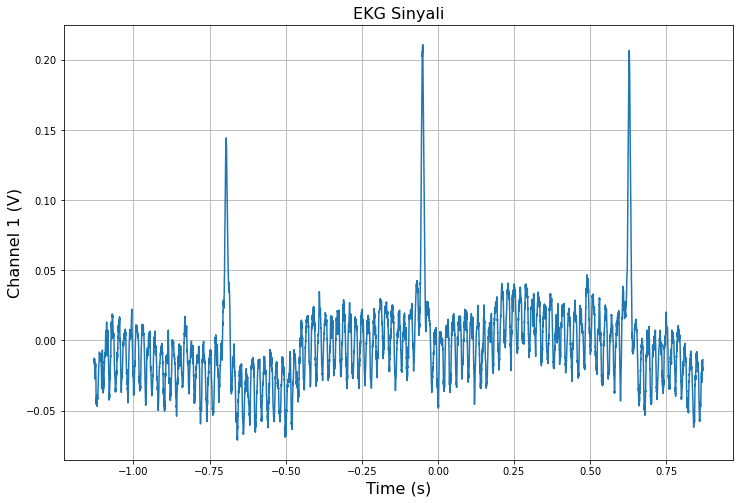

In [6]:
fig = plt.figure(figsize=(12,8))
plt.plot(data['Time (s)'],data['Channel 1 (V)'])
plt.title('EKG Sinyali',fontsize=16)
plt.xlabel('Time (s)',fontsize=16)
plt.ylabel('Channel 1 (V)',fontsize=16)
plt.grid()

# **EKG Sinyalinde Şebeke Geriliminden Kaynaklanan Gürültüleri Filtrelenmesi**

Text(0.5, 1.0, 'Frekans Spektrumu')

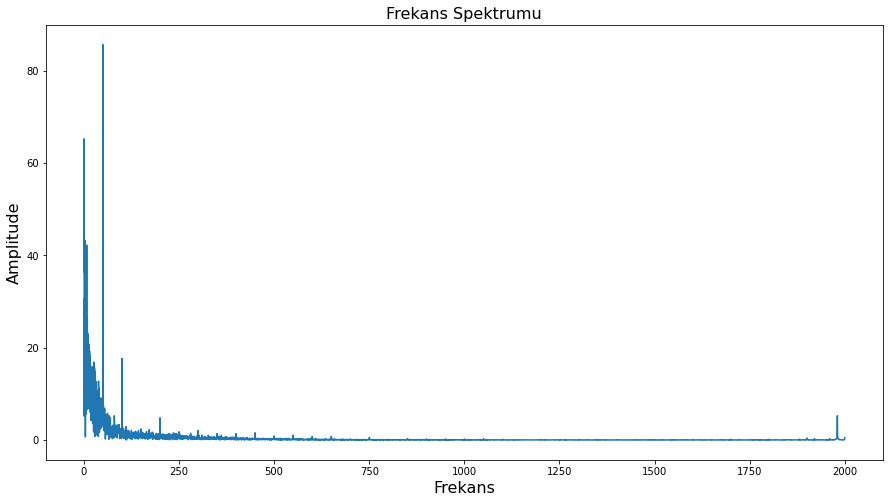

In [7]:
ekgData = data['Channel 1 (V)'].values
fftData = np.abs( fft(ekgData) )
fftLen = int(len(fftData) / 2) # değerlerin yarısı
frekans = np.linspace(0,f_sample/2, fftLen )

fig = plt.figure(figsize=(15,8))
plt.plot( frekans, fftData[0:fftLen] )
plt.ylabel('Amplitude',fontsize=16)
plt.xlabel('Frekans',fontsize=16)
plt.title('Frekans Spektrumu',fontsize=16)


Text(0.5, 1.0, '0-200 Hz Frekans Spektrumu')

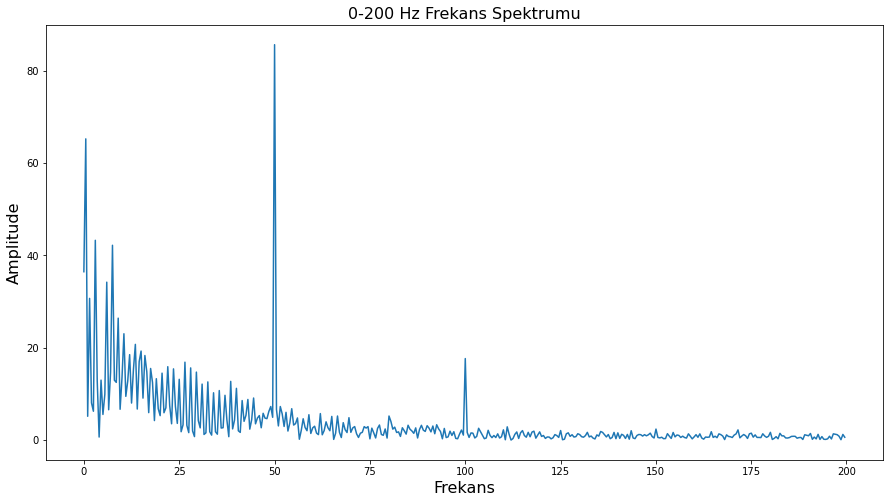

In [8]:
fig = plt.figure(figsize=(15,8))
plt.plot( frekans[0:400], fftData[0:400] )  # 0-200 frekans bandında yakınlaştrdığımız spektrum
plt.ylabel('Amplitude',fontsize=16)
plt.xlabel('Frekans',fontsize=16)
plt.title('0-200 Hz Frekans Spektrumu',fontsize=16)


Grafikte görüldüğü üzere şebeke elektriğinden dolayı **50 Hz** frekansında  gürültü vardır.

**Bu gürültüyü gidermek için 50 Hz frekansına band durduran filtre uygulamalıyız.**

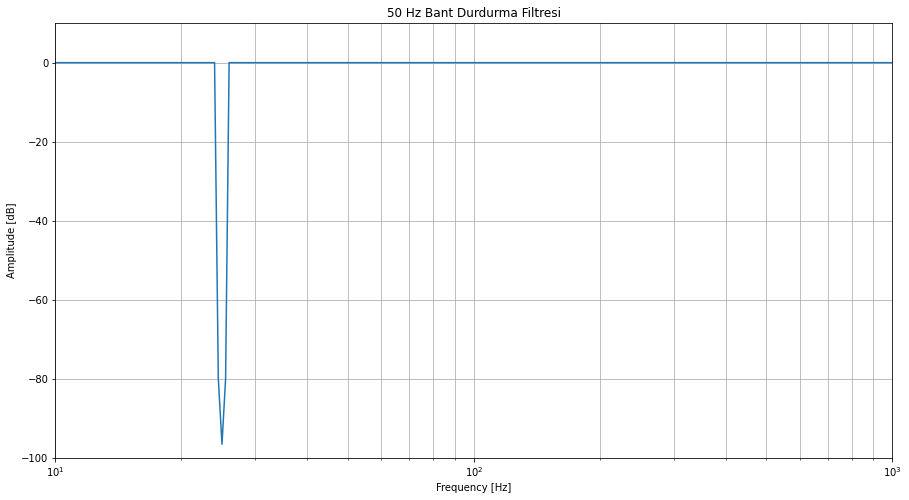

In [9]:
from scipy import signal

filter = signal.iirfilter(15, [49, 51], rs=80, btype='bandstop',ftype='cheby2', fs=4000,output='sos')
w, h = signal.sosfreqz(filter, 2000, fs=2000)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 1e-5)))
ax.set_title('50 Hz Bant Durdurma Filtresi')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()


In [11]:
ekgFiltered = signal.sosfilt(filter, ekgData)

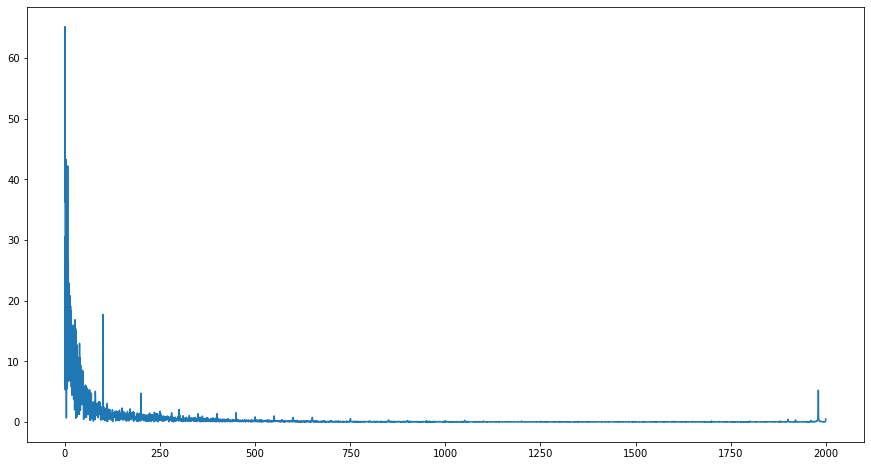

In [13]:
fftData = np.abs( fft(ekgFiltered) )
fftLen = int(len(fftData) / 2)
freqs = np.linspace(0,f_sample /2, fftLen )

matplotlib.rc('figure', figsize=(15, 8))

plt.figure()
plt.plot( freqs, fftData[0:fftLen] )


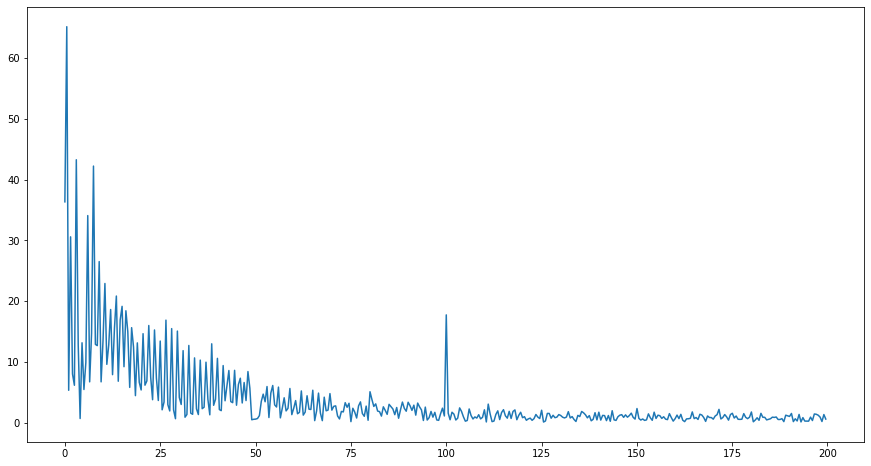

In [14]:
plt.figure() #yakınlaştırılmış hali
plt.plot( freqs[0:400], fftData[0:400] )

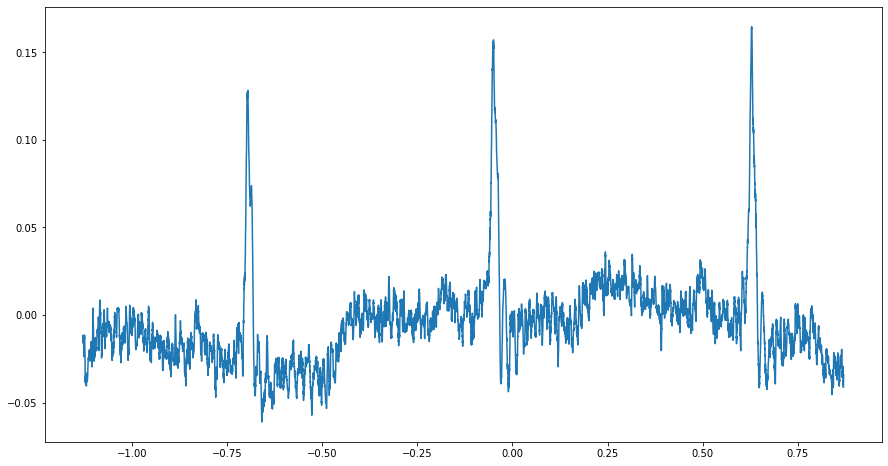

In [15]:
matplotlib.rc('figure', figsize=(15, 8))
plt.plot(data['Time (s)'],ekgFiltered)

# **EKG Sinyallerinde Kas (EMG) Gürültüsünün ve Taban Hattı Kaymasının Filtrelenmesi**

- Yüksek frekanslı gürültü olarak kas/EMG gürültüsü
EKG kaydı yapılırken hastanın hareket etmesi ile iskelet
kaslarının kasılması sonucu oluşmaktadır. Bu etki, EKG işaretinde istenmeyen değişikliklere neden olmakta ve
EKG sinyalinde bozulmalar meydana gelmektedir.
- EMG gürültüsünün frekans içeriği, 200 Hz den yüksek
frekanslarda etkili olduğu bilinmektedir
- EKG işareti kaydedilirken, işaret kaynağı olan kalp ile
EKG elektrodu arasında hastanın nefes alıp vermesi,
hareket etmesi ve elektrodun vücut yüzeyine temassızlığı
sonucu oluşan değişimler taban hattı kaymasını
oluşturmaktadır. Düşük frekanslı gürültüolarak taban
hattı kayması, 1 Hz’in altındaki frekanslarda meydana
gelmektedir. 
- Bant geçirme aralığı 1hz ve 200 hz aaralığında
frekansları geçiren bir filtre tasarlayarak, gürültüyü gidermeye çalışacağız. 

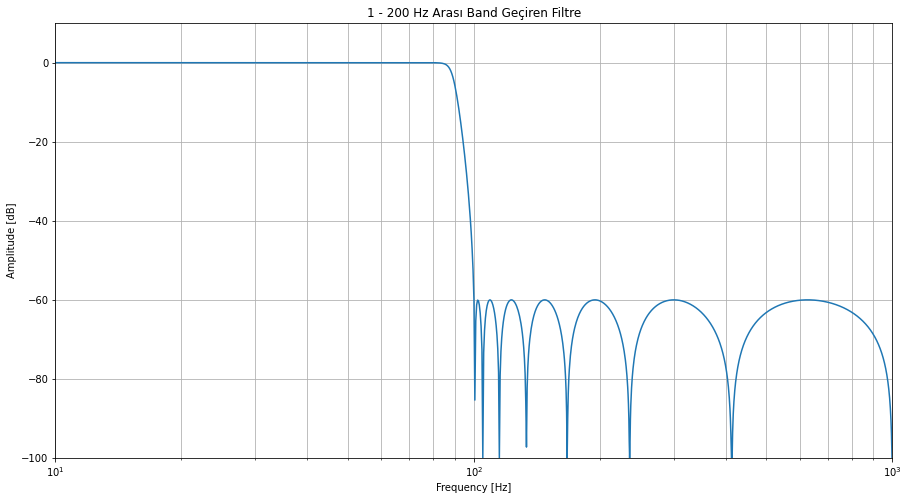

In [18]:
filter2 = signal.iirfilter(15, [1,200], rs=60, btype='bandpass',
                        analog=False, ftype='cheby2', fs=4000,
                        output='sos')
w, h = signal.sosfreqz(filter2, 2000, fs=2000)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.semilogx(w, 20 * np.log10(np.maximum(abs(h), 0.00001)))
ax.set_title('1 - 200 Hz Arası Band Geçiren Filtre')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude [dB]')
ax.axis((10, 1000, -100, 10))
ax.grid(which='both', axis='both')
plt.show()

In [19]:
ekgFiltered2 = signal.sosfilt(filter2, ekgFiltered)

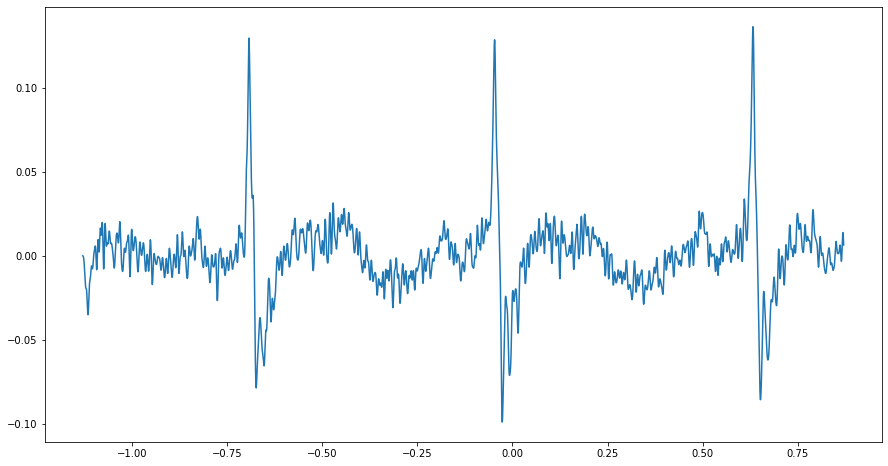

In [20]:
matplotlib.rc('figure', figsize=(15, 8))
plt.plot(data['Time (s)'],ekgFiltered2)

Son olarak, sinyale basit bir hareketli ortalama filtresi uygulanır. Bir sonraki şekil, EKG projemizin nihai sonucudur. Filtreleme işlemlerinden sonra, EKG bileşenlerinin çoğu daha temizdir ve artık EKG bileşenlerini sinyalden çıkarmak daha kolaydır.

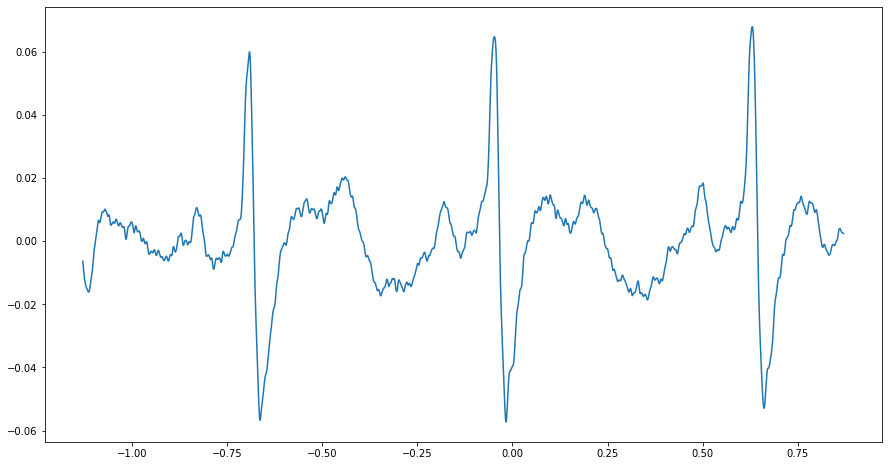

In [21]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

matplotlib.rc('figure', figsize=(15, 8))
plt.plot(data['Time (s)'],moving_average(ekgFiltered2, 100))